In [67]:
%pip install ipynb
%pip install nbimporter


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [68]:
# Synthetic dataset
from sklearn.datasets import make_classification
# Data processing
import pandas as pd
import numpy as np
from collections import Counter
# Visualization
import matplotlib.pyplot as plt
# Model and performance
from sklearn.svm import OneClassSVM
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_curve, auc
import seaborn as sns

sns.set(palette='rainbow', context='talk')
from sklearn.metrics import precision_recall_curve
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error



In [69]:
%run EDA.ipynb


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Functions

In [70]:
def split_inandout(outlier,inlier,target, df_,frac_out):
    df = df_.copy()
    class_label = target
    out_classes = pd.DataFrame()
    #Select the class you want to be outlier
    for out in outlier:
        out_class = out
        outliers_samples = df[df.target == out_class]
        outliers_samples = outliers_samples.sample(frac = frac_out)
        out_classes = pd.concat([out_classes, outliers_samples], ignore_index=False).sort_index()
        #print(out_classes.shape)
    
    #print(out_classes.shape)
    in_class = inlier
    inlier_samples = df[df.target == in_class]

    # Concatenate the modified outliers samples with the original inlier samples
    y = pd.concat([inlier_samples.target, out_classes.target], ignore_index=False).sort_index()
    y =[1 if i==inlier else 0 for i in y]
    print(Counter(y))
    x = pd.concat([inlier_samples.drop(columns=class_label), out_classes.drop(columns=class_label)], ignore_index=False).sort_index()

    return x,y

In [71]:
def split_TestTrain_normalize(x,y):
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=43,stratify=y)

        # Check the number of records
    print('The number of records in the training dataset is', X_train.shape[0])
    print('The number of records in the test dataset is', X_test.shape[0])
    print(Counter(y_train))
    
    # Assuming your dataset is a 2D array or a pandas DataFrame
    # Initialize the scaler
    #scaler = StandardScaler()
    #scaler = MinMaxScaler()
    scaler = RobustScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

In [72]:
def select_best_nu(X_train,y_train,nu):
    # Define the parameter grid to search
    param_grid = {
        'gamma': [0.1, 0.5, 1.0],  # range of gamma values to try
        'kernel': ['linear', 'rbf','sigmoid','poly']  # types of kernels to try
    }

    # Create an instance of the OneClassSVM
    model = OneClassSVM(nu=nu)
    #scoring = accuracy_score(y_test, prediction)
    # Create a grid search object
    grid_search = GridSearchCV(model, param_grid, scoring='accuracy',cv=5)

    # Perform grid search on your data
    grid_search.fit(X_train, y_train)  # X_train and y_train are your training data

    # Get the best parameters and accuracy score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Parameters: ", best_params)
    print("Best Accuracy Score: ", best_score)

    return best_params,best_score

In [73]:
def best_Kernel(X_train,X_test,y_train,y_test,gamma,nu,name):
    classical_kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    ds1_f1 = []

    for kernel in classical_kernels:
        # Train the one class support vector machine (SVM) model
        one_class_svm = OneClassSVM(nu=nu, kernel = kernel, gamma = gamma).fit(X_train)
        # Predict the anomalies
        prediction_ = one_class_svm.predict(X_test)
        prediction_ = [False if i==-1 else True for i in prediction_]
        print("{} kernel classification f1 score is {}".format(kernel,f1_score(y_test, prediction_)))
        ds1_f1.append(f1_score(y_test, prediction_))

    # Set the width of the bars
    bar_width = 0.4

    # Create a list of x positions for the bars
    x_pos = range(len(classical_kernels))

    # Create the bar plot
    plt.bar(x_pos, ds1_f1, width=bar_width)

    # Set the x-axis labels
    plt.xticks(x_pos, classical_kernels)

    # Set the y-axis label
    plt.ylabel('F1 Score')

    # Set the title of the graph
    plt.title('F1 Score for Different Kernels ('+name+' Dataset)')

    # Add the rounded values on top of each bar
    for i, value in enumerate(ds1_f1):
        rounded_value = round(value, 3)  # Round off to three decimal points
        plt.text(i, value, str(rounded_value), ha='center', va='bottom')

    # Show the plot
    plt.show()

In [74]:
def runAll_kernelsSVM(X_train,X_test,y_train,y_test, gamma,kernel,nu):
    
    #ds1_f1 = []
    predictions = []
    predictionsTrains = []

    
    # Train the one class support vector machine (SVM) model
    one_class_svm = OneClassSVM(nu=nu,kernel = kernel,gamma=gamma).fit(X_train)
        
    # Predict the anomalies
    test_prediction = one_class_svm.predict(X_test)
    #print("This is the test prediction: "+str(test_prediction))
    test_prediction = [0 if i==-1 else 1 for i in test_prediction]
    print("{} kernel accurnacy is {}".format(kernel,accuracy_score(y_test, test_prediction)))
    #print("This is the test prediction modified: "+str(prediction))
    #ds1_f1.append(f1_score(y_test, prediction))
    

    train_prediction = one_class_svm.predict(X_train)
    #print("This is the train prediction: "+str(train_prediction))
    predictionTrain = [0 if i==-1 else 1 for i in train_prediction]
    #print("This is the train prediction modified: "+str(predictionTrain))
    

    return test_prediction,predictionTrain

In [75]:
def scatterPlot(X_test,y_test,test_prediction,filename,feature1,feature2):    
# Put the testing dataset and predictions in the same dataframe
    X_test_ = X_test.copy()
    y_test_ = y_test.copy()
    df_test = pd.DataFrame(X_test_)
    df_test['y_test'] = np.array(y_test_)
    df_test['one_class_svm_prediction'] = test_prediction
    # Visualize the actual and predicted anomalies
    fig, ax = plt.subplots(figsize=(8, 6))

    # Well-classified samples
    well_classified = df_test[df_test['y_test'] == df_test['one_class_svm_prediction']]
    ax.scatter(well_classified[feature1], well_classified[feature2], c='green', label='Well Classified')

    # Wrongly classified samples
    wrong_classified = df_test[df_test['y_test'] != df_test['one_class_svm_prediction']]
    ax.scatter(wrong_classified[feature1], wrong_classified[feature2], c='red', label='Wrong Classification')

    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title('Well Classified vs Wrong Classification')
    ax.legend()

    plt.show()

In [76]:
def recallPlot(y_test,test_prediction,filename):    
    
    #labels = y_test
    #calculate precision and recall
    precision, recall, thresholds = precision_recall_curve(y_test, test_prediction)

    #create precision recall curve
    fig, ax = plt.subplots()
    ax.plot(recall, precision, color='purple')

    #add axis labels to plot
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')

    #display plot
    #plt.show()
    plt.savefig(filename)

In [77]:
def RocCurve_plot(y_train, y_test, train_prediction,test_prediction,filename):
    
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, train_prediction)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, test_prediction)
    plt.grid()
    plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
    plt.plot([0,1],[0,1],'g--')
    plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("AUC(ROC curve)")
    plt.grid(color='black', linestyle='-', linewidth=0.5)
    #plt.show()
    
    plt.savefig(filename)

# IRIS DATASET

In [78]:
dataset_iris, x ,y = irisData ()
target = 'target'
print("The dataset selected has shape: " + str(dataset_iris.shape) + " and for each class "+ str(Counter(dataset_iris[target])))

The dataset selected has shape: (150, 5) and for each class Counter({0: 50, 1: 50, 2: 50})


## Apply OCC-SVM

### For multi-class datasets we need to select 1 target class and then set an smaller amount of outliers

In [79]:
out_class = [0,2]
in_class = 1
outPer = 0.2
x_,y_ = split_inandout(out_class,in_class,target,dataset_iris,0.1)
X_train, X_test, y_train, y_test = split_TestTrain_normalize(x_,y_)

Counter({1: 50, 0: 10})
The number of records in the training dataset is 42
The number of records in the test dataset is 18
Counter({1: 35, 0: 7})


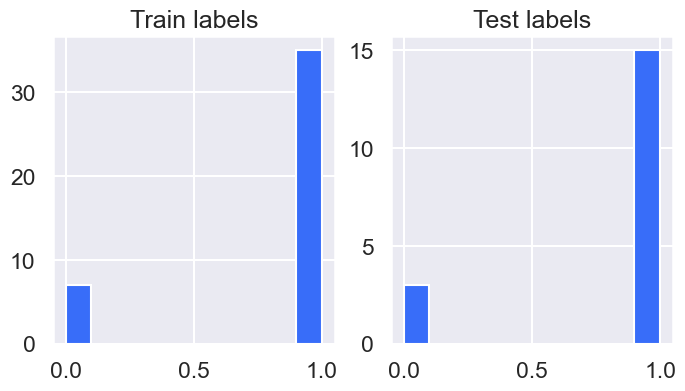

In [80]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].hist(y_train)
ax[0].set_title("Train labels")
ax[1].hist(y_test)
ax[1].set_title("Test labels")
plt.show()

### Now we proceed with the OCC-SVM

Best Parameters:  {'gamma': 1.0, 'kernel': 'sigmoid'}
Best Accuracy Score:  0.7444444444444445
linear kernel classification f1 score is 0.6923076923076923
poly kernel classification f1 score is 0.8275862068965518
rbf kernel classification f1 score is 0.6956521739130436
sigmoid kernel classification f1 score is 0.9032258064516129


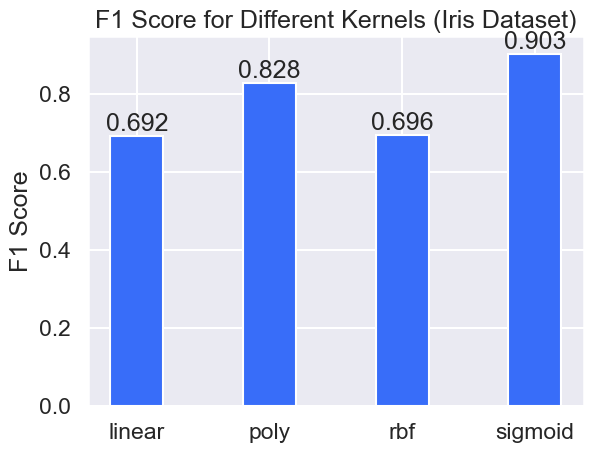

In [81]:
param,accurancy = select_best_nu(X_train,y_train,outPer)
best_Kernel(X_train,X_test,y_train,y_test,param['gamma'],outPer,'Iris')

In [82]:
test_prediction,train_prediction = runAll_kernelsSVM(X_train, X_test,y_train, y_test,'auto',param['kernel'],outPer)

sigmoid kernel accurnacy is 0.8888888888888888


### Evaluation Metrics

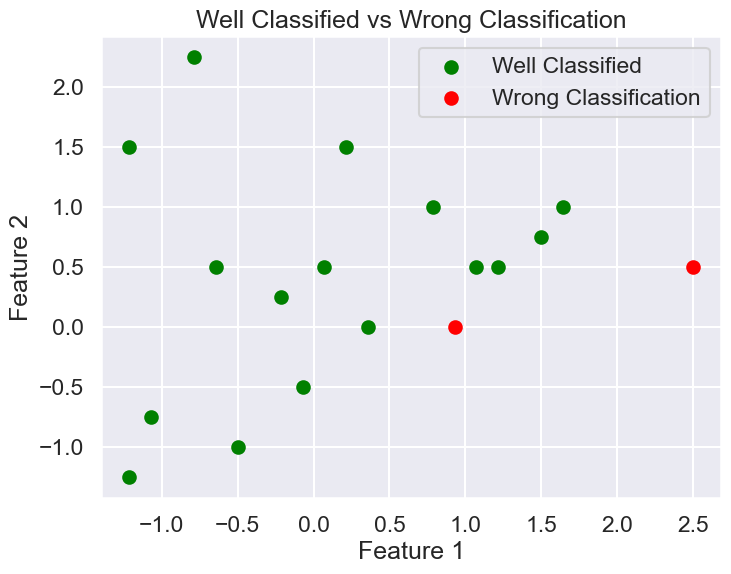

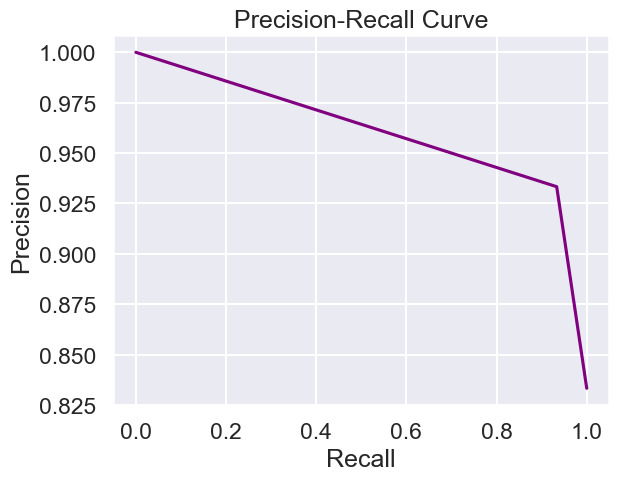

In [83]:
filename = '../figures/IrisData'

scatterPlot(X_test,y_test,test_prediction,filename+'_scatterPlot',0,1)
recallPlot(y_test,test_prediction,filename+'_recallPlot')


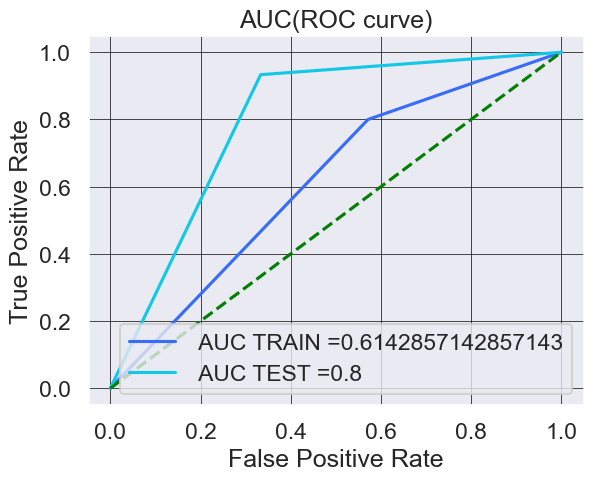

In [84]:
RocCurve_plot(y_train, y_test, train_prediction,test_prediction,filename+'_ROCplot')

# VOWEL DATASET

In [85]:
vowelDataset, x ,y = vowelData ()
vowelDataset = vowelDataset.rename(columns={'feature12':'target'})
#for vowels dataset
target = 'target'

print("The dataset selected has shape: " + str(vowelDataset.shape) + " and for each class "+ str(Counter(vowelDataset[target])))

The dataset selected has shape: (990, 13) and for each class Counter({0: 90, 1: 90, 2: 90, 3: 90, 4: 90, 5: 90, 6: 90, 7: 90, 8: 90, 9: 90, 10: 90})


## Apply OCC-SVM

### For multi-class datasets we need to select 1 target class and then set an smaller amount of outliers

In [86]:
out_class = [2,5,6,7,9]
in_class = 1
outPer = 0.1
x,y = split_inandout(out_class,in_class,target,vowelDataset,0.02)
# Train test split
X_train, X_test, y_train, y_test = split_TestTrain_normalize(x,y)


Counter({1: 90, 0: 10})
The number of records in the training dataset is 70
The number of records in the test dataset is 30
Counter({1: 63, 0: 7})


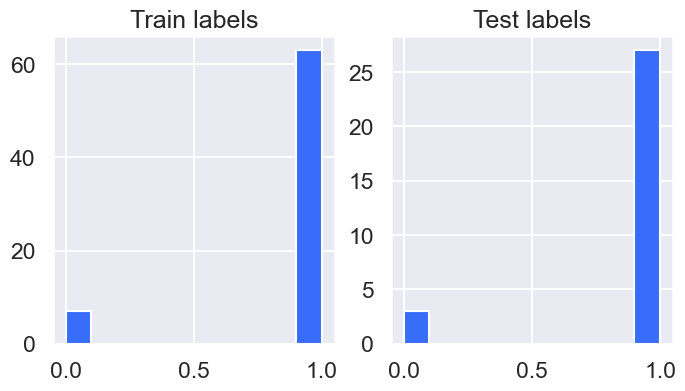

In [87]:
fig, ax = plt.subplots(1,2, figsize=(8,4))

ax[0].hist(y_train)
ax[0].set_title("Train labels")
ax[1].hist(y_test)
ax[1].set_title("Test labels")
plt.show()

### Now we proceed with the OCC-SVM

Best Parameters:  {'gamma': 1.0, 'kernel': 'sigmoid'}
Best Accuracy Score:  0.8142857142857143
linear kernel classification f1 score is 0.8679245283018868
poly kernel classification f1 score is 0.7391304347826088
rbf kernel classification f1 score is 0.4117647058823529
sigmoid kernel classification f1 score is 0.9285714285714286


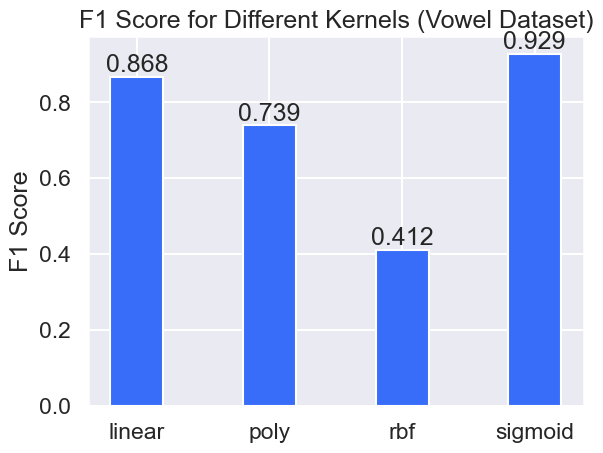

In [88]:
param,accurancy = select_best_nu(X_train,y_train,outPer)
best_Kernel(X_train,X_test,y_train,y_test,param['gamma'],outPer,'Vowel')

In [89]:
test_prediction,train_prediction = runAll_kernelsSVM(X_train, X_test,y_train, y_test,param['gamma'],param['kernel'],outPer)

sigmoid kernel accurnacy is 0.8666666666666667


### Evaluation Metrics

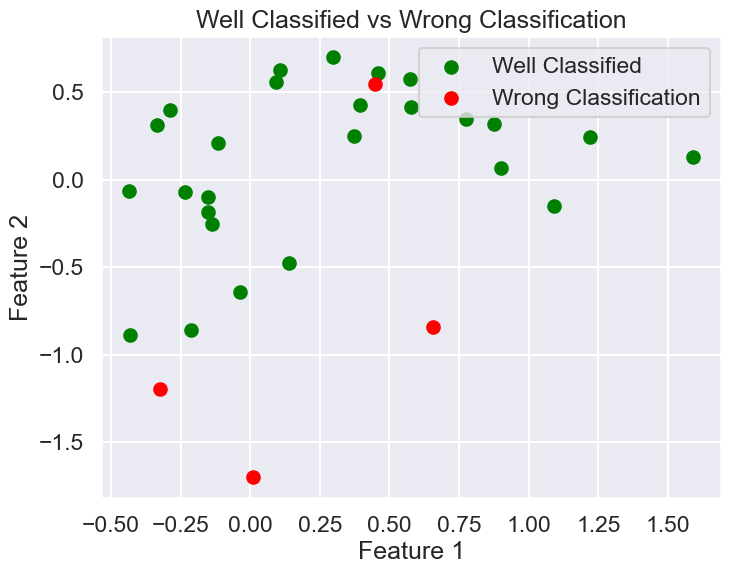

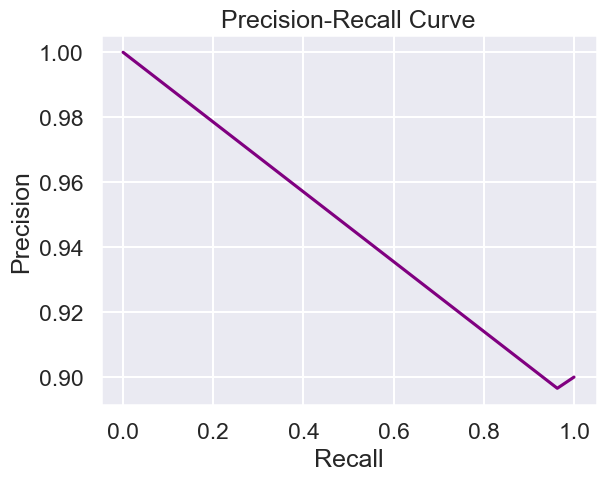

In [90]:
filename = '../figures/vowelData'

scatterPlot(X_test,y_test,test_prediction,filename+'_scatterPlot',4,5)
recallPlot(y_test,test_prediction,filename+'_recallPlot')


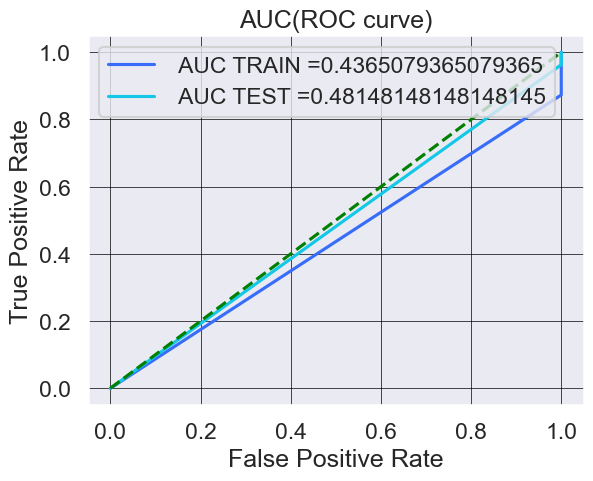

In [91]:
RocCurve_plot(y_train, y_test, train_prediction,test_prediction,filename+'_ROCplot')

# BREAST CANCER DATASET

In [92]:
breast_dataset, x ,y = breastcancerData()
target = 'target'

print("The dataset selected has shape: " + str(breast_dataset.shape) + " and for each class "+ str(Counter(breast_dataset[target])))

The dataset selected has shape: (569, 31) and for each class Counter({1: 357, 0: 212})


## Apply OCC-SVM

### For multi-class datasets we need to select 1 target class and then set an smaller amount of outliers

In [93]:
out_class = [0]
in_class = 1
outPer = 0.2
x_,y_ = split_inandout(out_class,in_class,target,breast_dataset,outPer)
# Train test split
X_train, X_test, y_train, y_test = split_TestTrain_normalize(x_,y_)


Counter({1: 357, 0: 42})
The number of records in the training dataset is 279
The number of records in the test dataset is 120
Counter({1: 250, 0: 29})


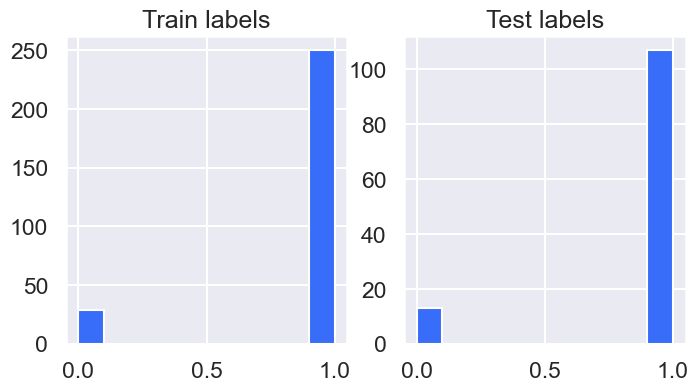

In [94]:
fig, ax = plt.subplots(1,2, figsize=(8,4))

ax[0].hist(y_train)
ax[0].set_title("Train labels")
ax[1].hist(y_test)
ax[1].set_title("Test labels")
plt.show()

In [95]:
# Reduce dimensions (the dataset now has a dimensionality of 31 attributes)
n_dim = 12 #number of qubits we want to use
pca = PCA(n_components=n_dim).fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

### Now we proceed with the OCC-SVM

Best Parameters:  {'gamma': 1.0, 'kernel': 'sigmoid'}
Best Accuracy Score:  0.8098701298701299
linear kernel classification f1 score is 0.8645833333333333
poly kernel classification f1 score is 0.6395348837209301
rbf kernel classification f1 score is 0.0
sigmoid kernel classification f1 score is 0.8656716417910447


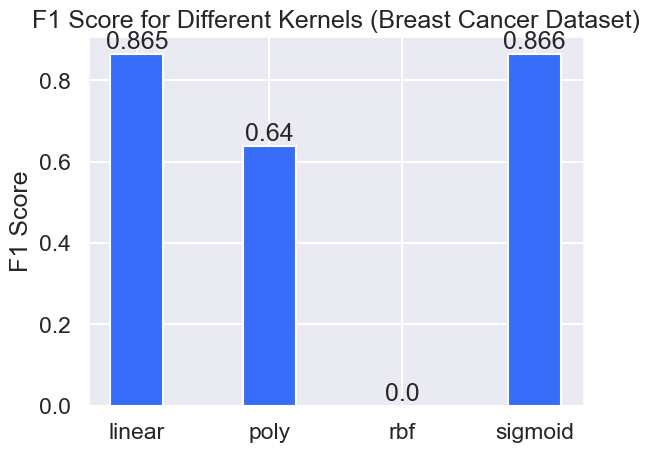

In [96]:
param,accurancy = select_best_nu(X_train,y_train,outPer)
best_Kernel(X_train,X_test,y_train,y_test,param['gamma'],outPer,'Breast Cancer')

In [97]:
test_prediction,train_prediction = runAll_kernelsSVM(X_train, X_test,y_train, y_test,'auto',param['kernel'],outPer)


sigmoid kernel accurnacy is 0.7833333333333333


### Evaluation Metrics

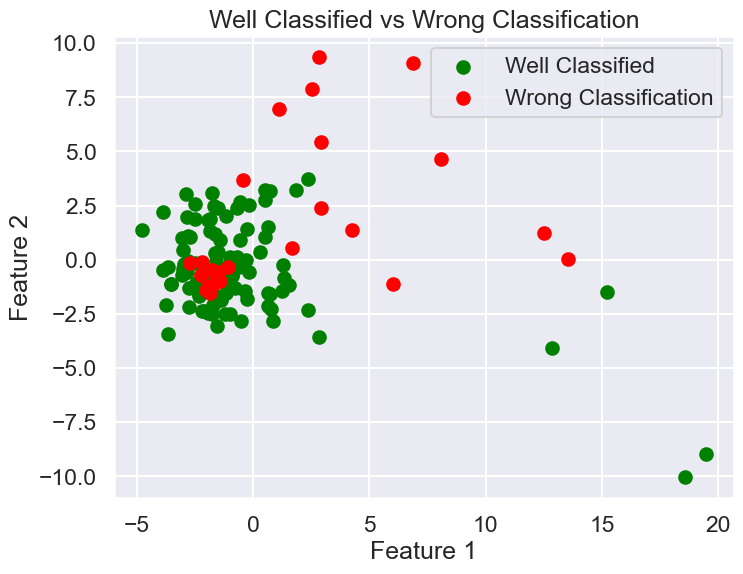

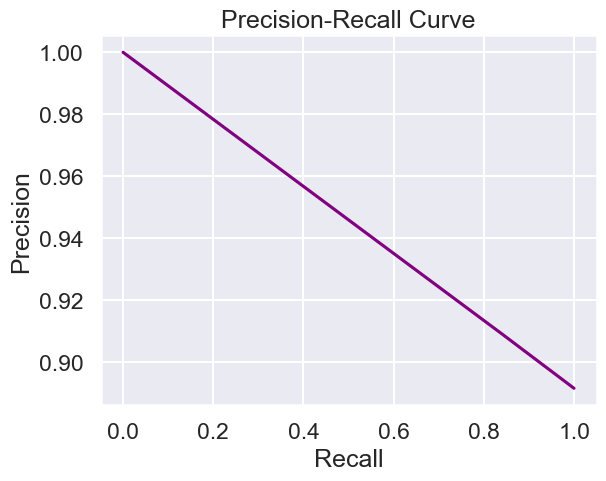

In [98]:

filename = '../figures/BreastData'

scatterPlot(X_test,y_test,test_prediction,filename+'_scatterPlot',0,1)
recallPlot(y_test,test_prediction,filename+'_recallPlot')

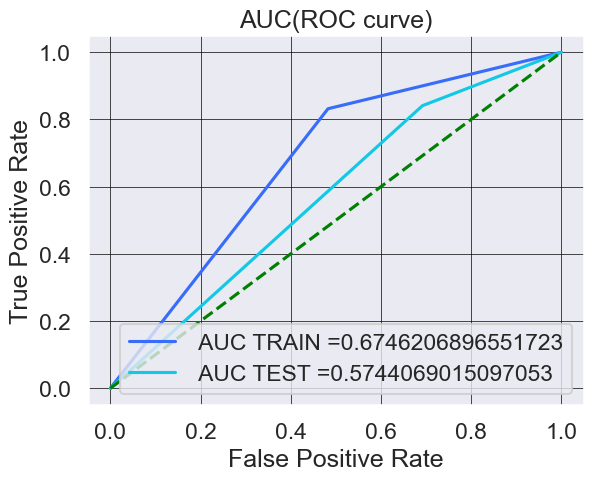

In [99]:
RocCurve_plot(y_train, y_test, train_prediction,test_prediction,filename+'_ROCplot')